# GMNS/Network Wrangler 2.0 Workshop

***Placeholder text from workshop overview:*** *Building and maintaining transportation networks for travel models is often time-consuming and error-prone. This workshop introduces the General Modeling Network Specification (GMNS), a standardized, human- and machine-readable format developed by the Zephyr Foundation with support from FHWA. GMNS enables easier sharing of routable road network files across platforms and agencies.  Participants will also explore Network Wrangler 2.0, an open-source Python tool that simplifies network editing through “Project Cards” - standardized, human- and machine-readable text files that describe proposed changes to roadway, transit, pedestrian, or bicycle infrastructure. The tool automates network updates, supports scenario management, and facilitates collaboration across agencies and software platforms.  This hands-on workshop will guide participants through building GMNS- and Network Wrangler-ready travel model networks from scratch using open-source data. Attendees will learn how to create network scenarios with Network Wrangler and perform network analysis with GMNS standard networks, including transit accessibility evaluation. Live demonstrations will showcase how these tools streamline network development and scenario management for regional transportation planning.*  


## Workflow Overview:

*Insert updata workflow*

In [ ]:
import argparse
import datetime
import pathlib
import pickle
import pprint
import requests
import statistics
import sys
from typing import Any, Optional, Tuple, Union

import networkx
import osmnx
import numpy as np
import pandas as pd
import geopandas as gpd
import pygris
import shapely.geometry

import folium
from folium import plugins
import seaborn as sns

import tableau_utils
import network_wrangler
from network_wrangler import WranglerLogger
from network_wrangler.params import LAT_LON_CRS
from network_wrangler.roadway.network import RoadwayNetwork
from network_wrangler.roadway.io import load_roadway_from_dataframes, write_roadway
from network_wrangler.roadway.clip import clip_roadway, clip_roadway_to_dfs
from network_wrangler.models.gtfs.gtfs import GtfsModel
from network_wrangler.transit.feed.feed import Feed
from network_wrangler.transit.network import TransitNetwork
from network_wrangler.transit.io import load_feed_from_path, write_transit, load_transit
from network_wrangler.models.gtfs.types import RouteType
from network_wrangler.utils.transit import \
  drop_transit_agency, filter_transit_by_boundary, create_feed_from_gtfs_model
from network_wrangler.roadway.centroids import FitForCentroidConnection, add_centroid_nodes, add_centroid_connectors

from visualization import *

import sys
sys.path.append('../create_baseyear_network')
from create_mtc_network_from_OSM import(
    stepa_standardize_attributes,
    step1_download_osm_network,
    step2_simplify_network_topology,
    step3_assign_county_node_link_numbering,
    step4_add_centroids_and_connectors,
    step5_prepare_gtfs_transit_data,
    step6_create_transit_network,
)

In [2]:
OUTPUT_DIR = pathlib.Path("data/processed")
INPUT_2023GTFS = pathlib.Path("M:/Data/Transit/511/2023-09")

## Step 1: Download OSM network data
Gets raw road network from OpenStreetMap

In [3]:
# Download the OSM network data for San Francisco county
g = step1_download_osm_network(county="San Francisco", output_dir=OUTPUT_DIR) 

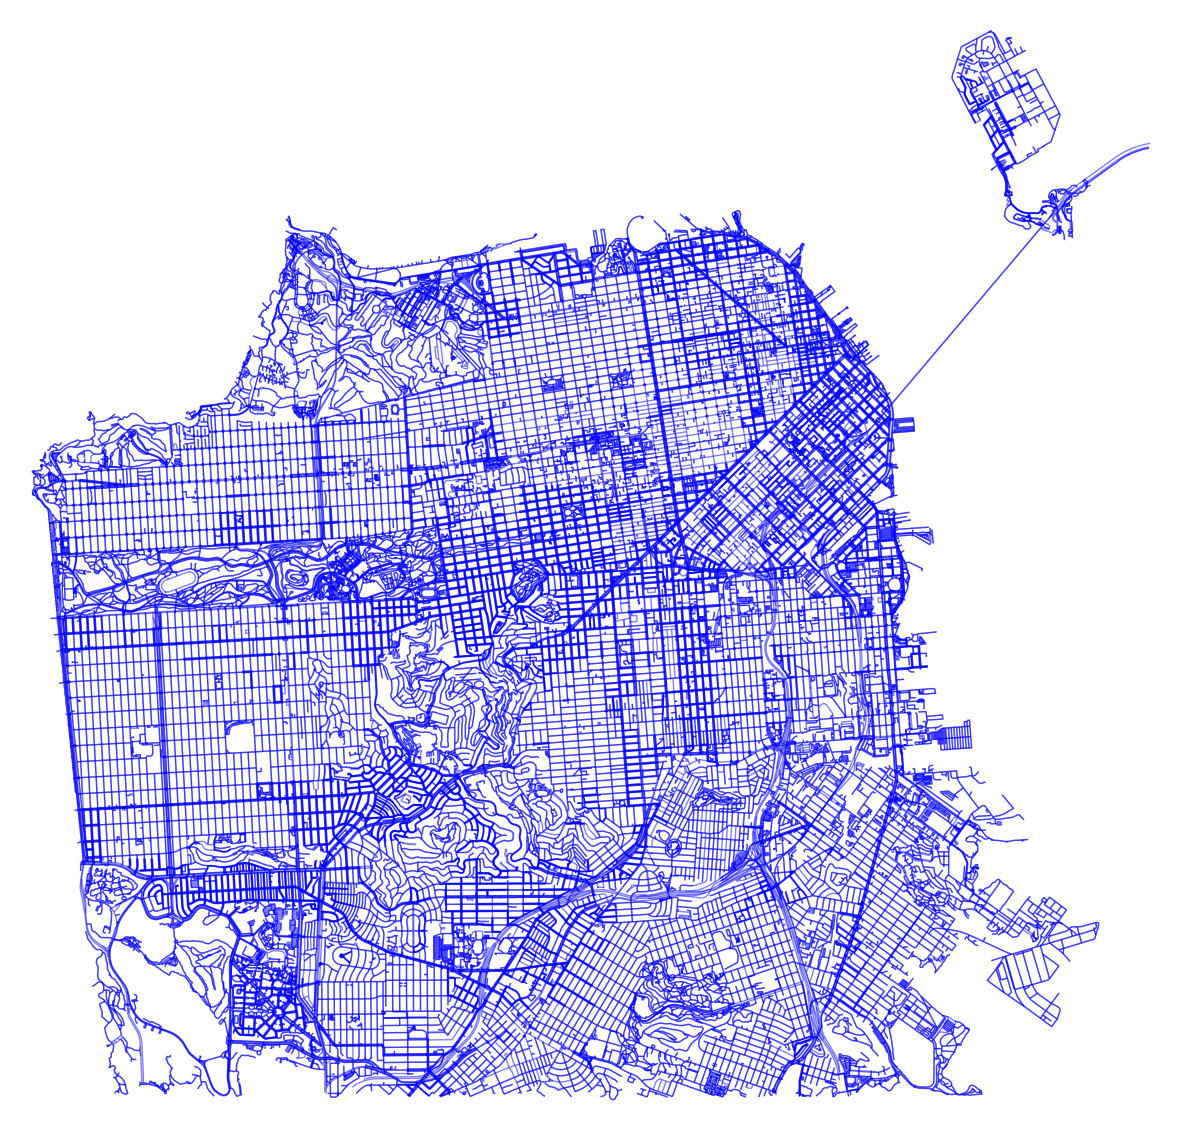

In [4]:
# Visualize the network
fig, ax = create_osmnx_plot(g)

## Step 1A: Standardize attributes (and write)  
Note: we don't keep the results of this, since we'll use version from the simplified graph  
*VIZ: visualize complicated block - van ness with bus lanes and footway a couple blocks north of market*

In [5]:
stepa_standardize_attributes(g, county="San Francisco", prefix="1a_original_", output_dir=OUTPUT_DIR, output_formats=["geojson"])

(            A        B  key  \
 0     1000000  1000001    0   
 1     1000001  1024521    0   
 2     1000001  1024568    0   
 3     1000002  1000003    0   
 6     1000003  1029750    0   
 ...       ...      ...  ...   
 1027  1057288  1057289    0   
 1028  1057289  1057288    0   
 1029  1057316  1056476    0   
 1030  1057637  1057638    0   
 1031  1057638  1057637    0   
 
                                             osm_link_id   highway oneway  \
 0                                             396123635   footway  False   
 1                                              32399102   footway  False   
 2                                              32399102   footway  False   
 3     [661905446, 50691047, 52721870, 52527662, 5069...  motorway   True   
 6                               [237731428, 1212176124]  motorway   True   
 ...                                                 ...       ...    ...   
 1027                                         1213210819  elevator  False  

## Step 2: Simplify network topology  
Consolidates intersections while preserving connectivity

In [6]:
simplified_g = step2_simplify_network_topology(g, county="San Francisco", output_dir=OUTPUT_DIR)

=== Network Comparison: Original OSM vs Simplified OSM ===

📊 BASIC STATISTICS
Nodes: 57,674 → 25,662 (44.5% remaining)
Edges: 169,335 → 91,669 (54.1% remaining)
Nodes removed: 32,012 (55.5%)
Edges removed: 77,666 (45.9%)

🔗 CONNECTIVITY ANALYSIS
Average degree: 5.87 → 7.14
Max degree: 16 → 46

Degree 2 nodes (typical street continuation): 6,502 → 4,000
Degree 3 nodes (T-intersections): 1,543 → 839
Degree 4+ nodes (complex intersections): 49,547 → 20,795

📏 EDGE LENGTH ANALYSIS
Average edge length: 42.8m → 209.4m
Total network length: 7253.1km → 19199.2km
Shortest edge: 0.0m → 12.2m
Longest edge: 3697.1m → 12131.6m


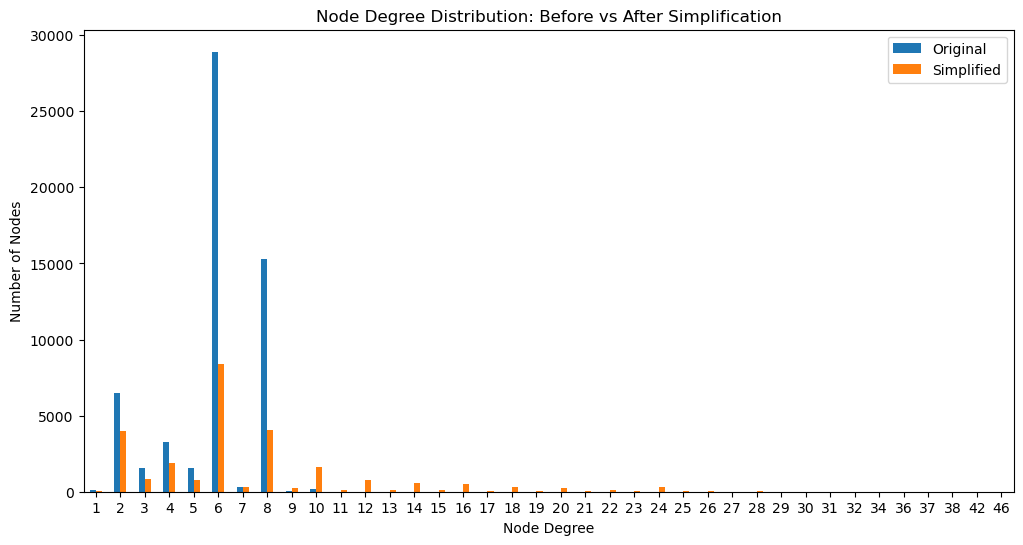

In [7]:
compare_original_and_simplified_networks(g, simplified_g)
plot_node_degree_changes(g, simplified_g)

## Step 2A Standardize attributes and write
*VIZ: same as 1a for contrast*

In [8]:
links_gdf, nodes_gdf = stepa_standardize_attributes(simplified_g, county="San Francisco", prefix="2a_simplified", output_dir=OUTPUT_DIR, output_formats=["geojson"])

In [ ]:
orig_links_gdf_clip, links_gdf_clip = clip_original_and_simplified_links(g, links_gdf)

In [ ]:
map_original_and_simplified_links(orig_links_gdf_clip, links_gdf_clip)

c:\Users\jahrenholtz\AppData\Local\anaconda3\envs\network_wrangler\lib\site-packages\geopandas\geodataframe.py:1046: FutureWarning: Starting with NumPy 2.0, the behavior of the 'copy' keyword has changed and passing 'copy=False' raises an error when returning a zero-copy NumPy array is not possible. pandas will follow this behavior starting with pandas 3.0.
This conversion to NumPy requires a copy, but 'copy=False' was passed. Consider using 'np.asarray(..)' instead.
  ids = np.array(self.index, copy=False)
c:\Users\jahrenholtz\AppData\Local\anaconda3\envs\network_wrangler\lib\site-packages\geopandas\geodataframe.py:1046: FutureWarning: Starting with NumPy 2.0, the behavior of the 'copy' keyword has changed and passing 'copy=False' raises an error when returning a zero-copy NumPy array is not possible. pandas will follow this behavior starting with pandas 3.0.
This conversion to NumPy requires a copy, but 'copy=False' was passed. Consider using 'np.asarray(..)' instead.
  ids = np.arra

In [ ]:
orig_links_gdf_clip["highway"].unique()

## Step 3: Assign county-specific numbering and create RoadwayNetwork object  
This also drops columns we're done with and writes the roadway network

In [ ]:
roadway_network = step3_assign_county_node_link_numbering(links_gdf, nodes_gdf, county="San Francisco", output_dir=OUTPUT_DIR, output_formats=["geojson"])

## Step 4: Add centroids and centroid connectors  

In [ ]:
step4_add_centroids_and_connectors(roadway_network, county="San Francisco", output_dir=OUTPUT_DIR, output_formats=["geojson"])

## STEP 5: Prepare GTFS transit data: Read and filter to service date, relevant operators. Creates GtfsModel object  
This also writes the GtfsModel as GTFS

In [ ]:
gtfs_model = step5_prepare_gtfs_transit_data(county="San Francisco", input_gtfs=INPUT_2023GTFS, output_dir=OUTPUT_DIR)

# STEP 6: Create TransitNetwork by integrating GtfsModel with RoadwayNetwork to create a Wrangler-flavored Feed object  
This writes the RoadwayNetwork and TransitNetwork

In [ ]:
transit_network = step6_create_transit_network(gtfs_model, roadway_network, county="San Francisco", output_dir=OUTPUT_DIR, output_formats=["parquet"])